# Global representation of meshes using Euclidean space

In [1]:
import shutil

import numpy as np
import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
import pyvista as pv
from geomstats.geometry.pullback_metric import PullbackDiffeoMetric
from matplotlib import pyplot as plt
from polpo.mesh.geometry import (
    DiscreteSurfaces,
    L2SurfacesMetric,
    PvSurfaceToArray,
    SurfacesSpace,
)
from polpo.mesh.surface import PvSurface
from polpo.preprocessing.load.pregnancy.jacobs import (
    MeshLoader,
    TabularDataLoader,
    get_subject_ids,
)
from polpo.preprocessing.mesh.io import DictMeshWriter, PvReader
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.str import TryToInt
from polpo.protocol.pt_to_global import Protocol, VectorTransport
from polpo.protocol.pt_to_global.euclidean import (
    EuclideanGlobalTemplateFinder,
    EuclideanTemplateFinder,
)
from polpo.protocol.pt_to_global.pregnancy import StageKeysDatasetFilter
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
RECOMPUTE = False
DEBUG = False
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
# TODO: can still improve folder structure
# TODO: rename? e.g. atlas -> pre-atlas

# TODO:
RESULTS_DIR = putils.get_results_path() / "regression_example_euclidean"

ATLAS_DIR = RESULTS_DIR / "atlases"
MESHES_DIR = RESULTS_DIR / "meshes"
REGISTRATIONS_DIR = RESULTS_DIR / "registrations"
TRANSPORTS_DIR = RESULTS_DIR / "transports"
# TODO: this is a bad name, global meshes?
PARALLEL_SHOOT_DIR = RESULTS_DIR / "parallel_shoot"
VELOCITIES_DIR = RESULTS_DIR / "velocities"

if RESULTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(RESULTS_DIR)

data_dir = "/home/data/maternal" if putils.in_frank() else "~/.herbrain/data/maternal"

In [4]:
subject_ids = get_subject_ids(sort=True, include_male=True)

subject_ids

['01', '1001B', '1004B', '1009B', '2004B']

In [5]:
def _sub_id2name(sub_id):
    # TODO: update to use `-`
    return f"sub_{sub_id}"

In [6]:
path2meshes = MeshLoader(
    derivative="enigma",
    subject_subset=subject_ids,
    struct_subset=["L_Hipp"],
    as_mesh=True,
    data_dir=data_dir,
) + ppdict.ExtractUniqueKey(nested=True)


if DEBUG:
    path2meshes += ppdict.DictMap(ppdict.TruncateDict(n_keys=8))


# subject_id, session_id
raw_meshes = path2meshes()

print("Number of meshes for:")
for subject_id, meshes in raw_meshes.items():
    print(f"  -subject {subject_id}: {len(meshes)}")

Number of meshes for:
  -subject 01: 26
  -subject 1001B: 14
  -subject 1004B: 22
  -subject 1009B: 10
  -subject 2004B: 26


In [7]:
df = TabularDataLoader(data_dir=data_dir, subject_subset=subject_ids)()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/maternal/maternal_brain_project_pilot/rawdata/28Baby_Hormones.csv').


In [8]:
# Rigid alignment of all meshes to the first mesh of subject 01
align_pipe = RigidAlignment(
    target=putils.get_first(raw_meshes["01"]),
    known_correspondences=True,
)

meshes = ppdict.DictMap(align_pipe)(raw_meshes)

In [9]:
def _key2name(key):
    sub_id, session_id = key.split("/")
    return f"{_sub_id2name(sub_id)}/mesh_{session_id}"


meshes2files = (
    ppdict.UnnestDict(sep="/")
    + DictMeshWriter(dirname=MESHES_DIR, ext="vtk", key2name=_key2name)
    + ppdict.NestDict(sep="/")
    + ppdict.DictMap(ppdict.DictMap(key_step=TryToInt(), step=PvReader() + PvSurface))
)

# subject, session: filename
dataset = meshes2files(meshes)

In [10]:
random_mesh = ppdict.ExtractRandomKey()(ppdict.ExtractRandomKey()(dataset))

image_space = DiscreteSurfaces(random_mesh.faces, equip=False).equip_with_metric(
    L2SurfacesMetric
)

space = SurfacesSpace().equip_with_metric(
    PullbackDiffeoMetric,
    image_space=image_space,
    diffeo=PvSurfaceToArray(random_mesh.faces),
    signature=(None, 0),  # TODO: fix
)

In [11]:
protocol = Protocol(
    template_finder=EuclideanTemplateFinder(space),
    global_template_finder=EuclideanGlobalTemplateFinder(space),
    local_space=space,
    # dataset_filter_for_templates=StageKeysDatasetFilter(df),
    dataset_filter_for_templates=lambda x: x,
    vector_transport=VectorTransport(space),
)

In [12]:
protocol.run(dataset)

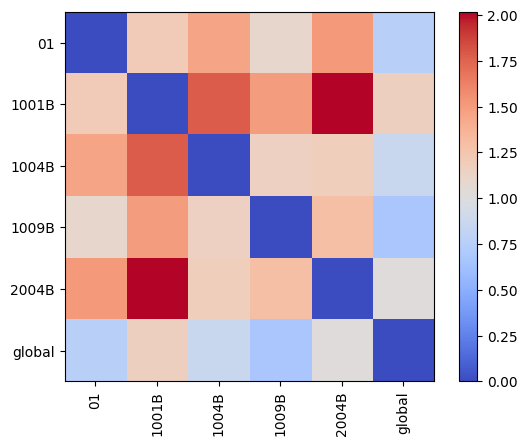

In [13]:
meshes = protocol.templates_

template_dists = putils.pairwise_dists(
    list(protocol.templates_.values()),
    space.metric,
)

fig, ax = plt.subplots()

im = ax.imshow(template_dists, cmap="coolwarm")

plt.colorbar(im)

ticks = range(len(meshes))
ticks_labels = meshes.keys()
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_labels, rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_labels);

In [14]:
global_meshes = protocol.global_reprs_
flat_global_meshes = ppdict.UnnestDict(sep="-")(global_meshes)

dists = putils.pairwise_dists(
    list(flat_global_meshes.values()),
    space.metric,
)

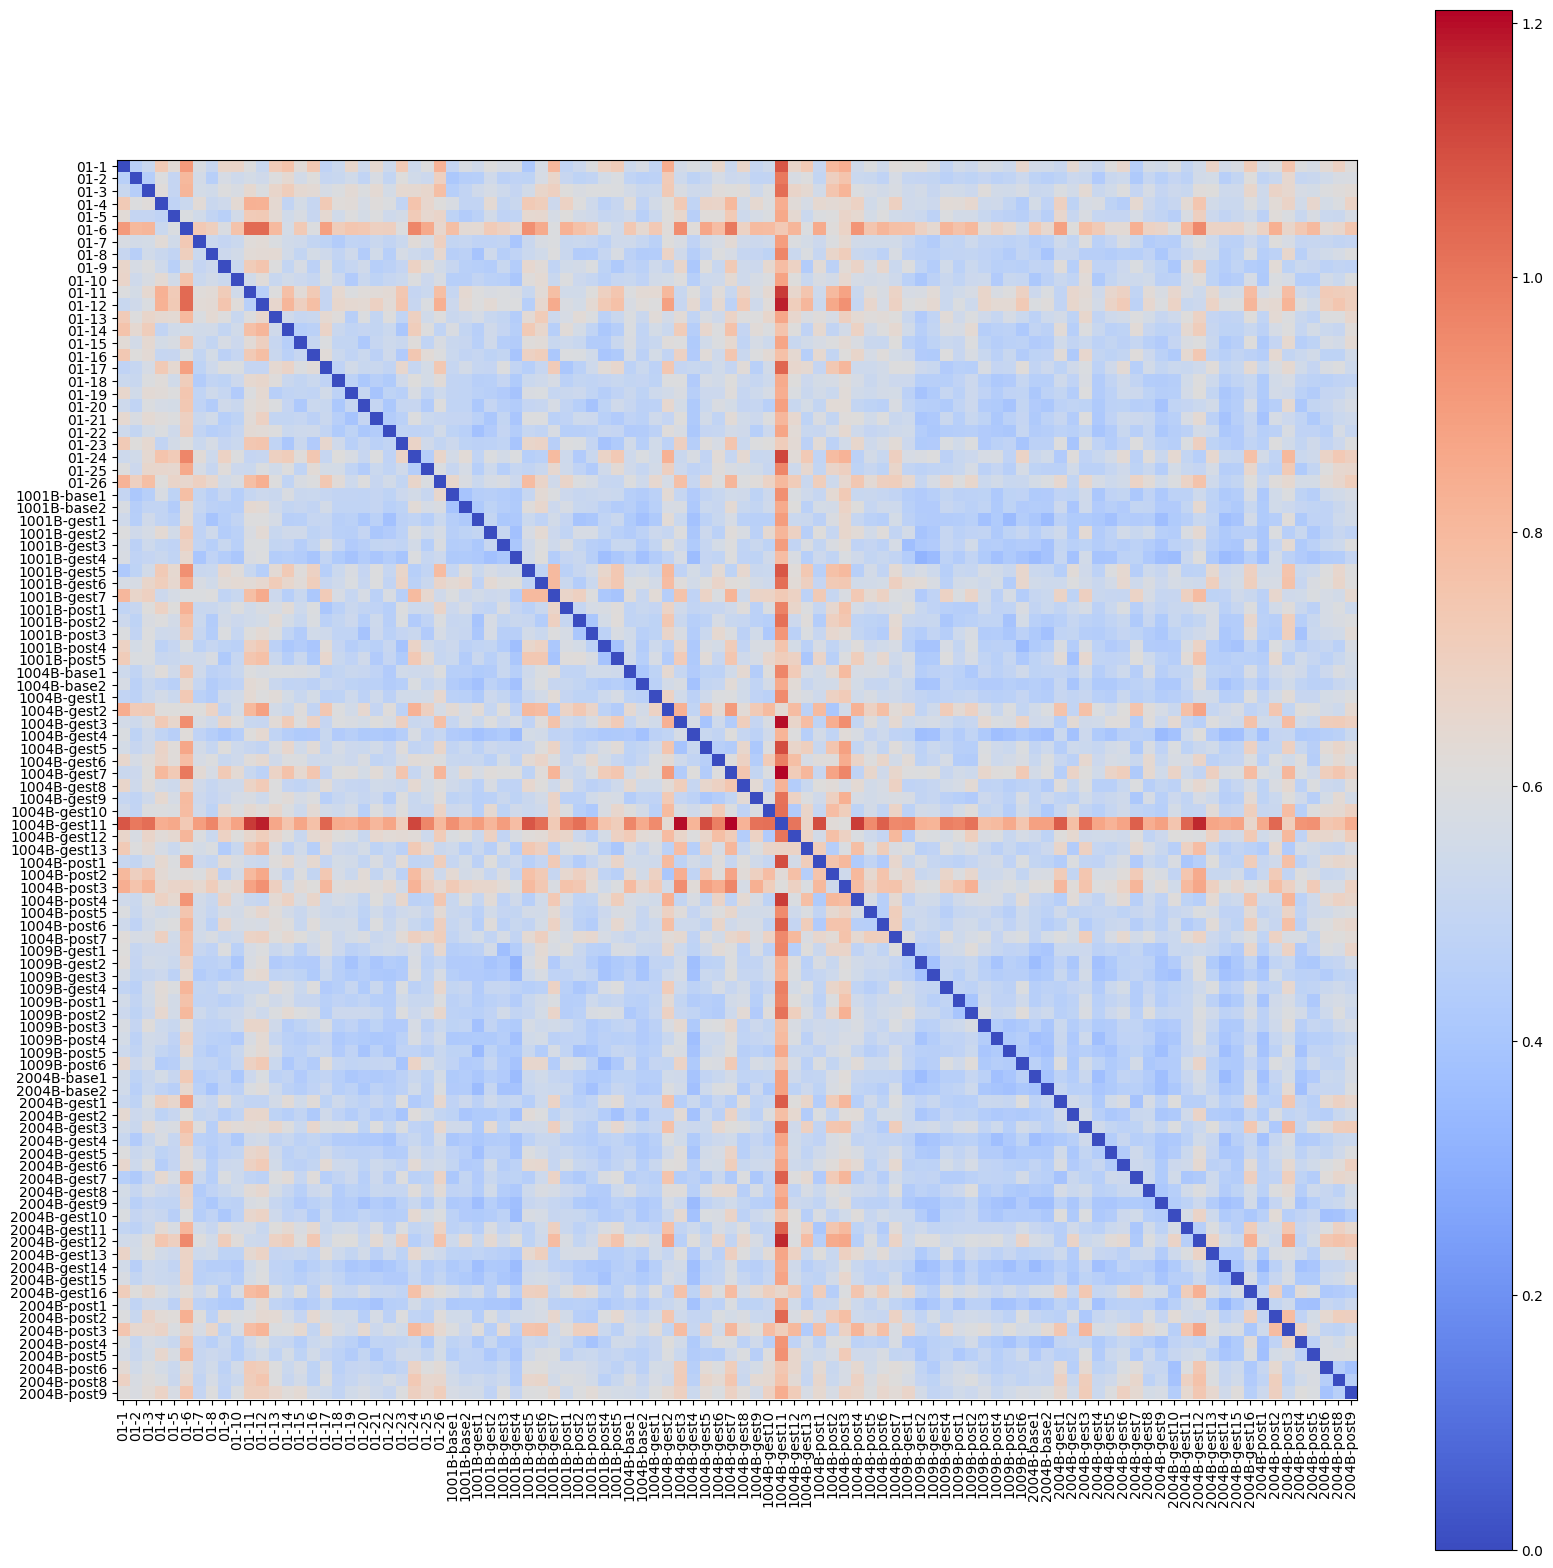

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))

im = ax.imshow(dists, cmap="coolwarm")

plt.colorbar(im)

ticks = range(len(flat_global_meshes))
ticks_labels = flat_global_meshes.keys()
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_labels, rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_labels)

plt.tick_params(axis="both", labelsize=10)

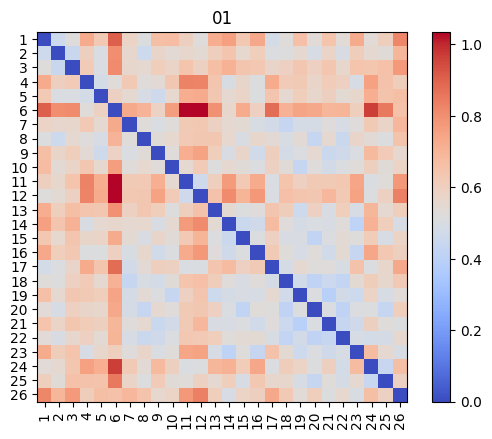

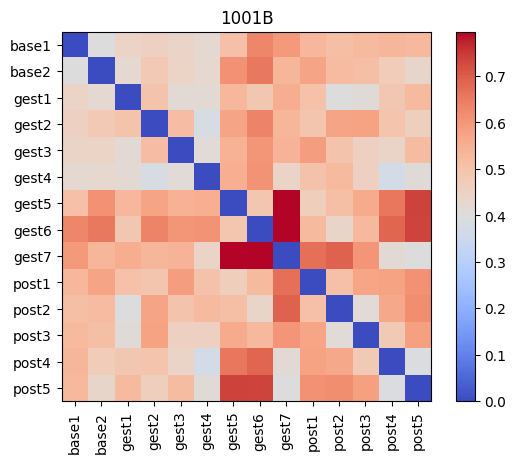

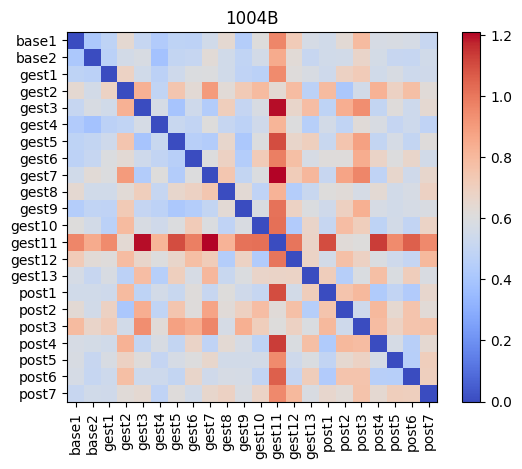

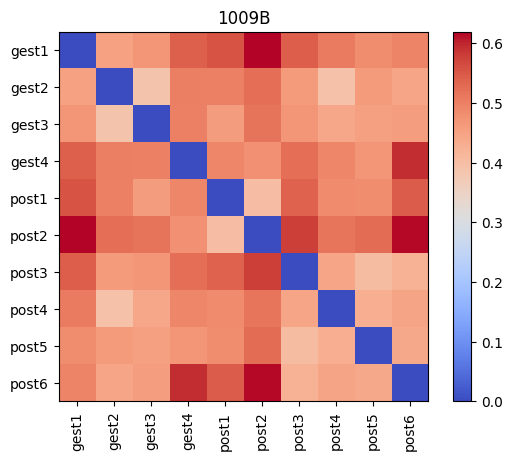

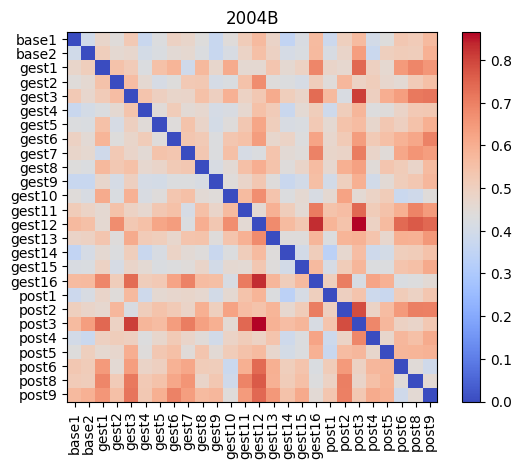

In [16]:
subj_dists_block = putils.get_diag_blocks_by_size(
    dists, [len(meshes) for meshes in global_meshes.values()]
)

for (subj, session_meshes), dists_subj in zip(global_meshes.items(), subj_dists_block):
    fig, ax = plt.subplots()

    im = ax.imshow(dists_subj, cmap="coolwarm")

    plt.colorbar(im)

    ticks = range(len(session_meshes))
    ticks_labels = session_meshes.keys()
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_labels, rotation=90)

    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks_labels)

    ax.set_title(subj)

## Is it possible to cluster the meshes by subject?

In [17]:
# TODO: move this analysis to local space

In [18]:
ac_estimators = dict(
    (
        f"ac-{linkage}",
        AgglomerativeClustering(
            n_clusters=len(subject_ids),
            metric="precomputed",
            linkage=linkage,
        ),
    )
    for linkage in ("complete", "average", "single")
)

for estimator in ac_estimators.values():
    estimator.fit(dists)

In [19]:
estimator = SpectralClustering(
    n_clusters=len(subject_ids),
    affinity="precomputed",
    assign_labels="kmeans",
)

spectral_estimators = {}

for gamma in (0.1, 1.0, 10.0):
    affinity_matrix = np.exp(-gamma * dists**2)

    spectral_estimators[f"spectral-{gamma}"] = estimator.__sklearn_clone__().fit(
        affinity_matrix
    )

In [20]:
estimators = ac_estimators | spectral_estimators

In [21]:
n_meshes_subj = [len(meshes) for meshes in global_meshes.values()]

for name, estimator in estimators.items():
    print(name)

    start = 0
    for increment in n_meshes_subj:
        end = start + increment
        labels_subj = estimator.labels_[start:end]

        most_common = max(set(labels_subj), key=labels_subj.tolist().count)

        print(
            f"{labels_subj}, {most_common}, {np.sum(labels_subj==most_common)}/{len(labels_subj)}"
        )

        start = end

    print("")

ac-complete
[4 1 1 0 0 0 1 1 0 1 4 4 1 0 3 0 4 1 1 1 1 1 0 3 3 0], 1, 11/26
[1 1 1 1 3 1 4 3 0 4 3 3 0 0], 1, 5/14
[1 1 1 0 4 1 4 1 4 3 1 3 2 3 0 3 0 2 3 3 3 1], 1, 7/22
[3 1 1 3 1 1 1 1 1 0], 1, 7/10
[1 3 4 0 3 1 1 0 4 1 1 1 3 3 1 1 1 0 1 3 0 3 1 1 1 1], 1, 14/26

ac-average
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3], 0, 24/26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0], 0, 14/14
[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0 0 0 0], 0, 20/22
[0 0 0 0 0 0 0 0 0 0], 0, 10/10
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 0, 26/26

ac-single
[0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 0, 25/26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0], 0, 14/14
[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 2 0 0 0 1], 0, 19/22
[0 0 0 0 0 0 0 0 0 0], 0, 10/10
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], 0, 26/26

spectral-0.1
[0 3 3 4 4 4 0 4 0 1 1 3 1 1 2 1 0 0 1 2 1 0 1 2 2 1], 1, 9/26
[3 4 2 1 2 1 0 0 1 0 2 2 1 1], 1, 5/14
[3 3 3 1 3 1 3 3 3 2 3 2 0 2 1 2 1 2 2 2 2 3], 3, 9/22
[2 1 1 0 3 3 2 1 2 4], 1, 3/1